<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   student_id   100000 non-null  int64  
 1   gender       100000 non-null  object 
 2   attendance   100000 non-null  int64  
 3   study_hours  100000 non-null  float64
 4   test1        100000 non-null  int64  
 5   test2        100000 non-null  int64  
 6   test3        100000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.3+ MB


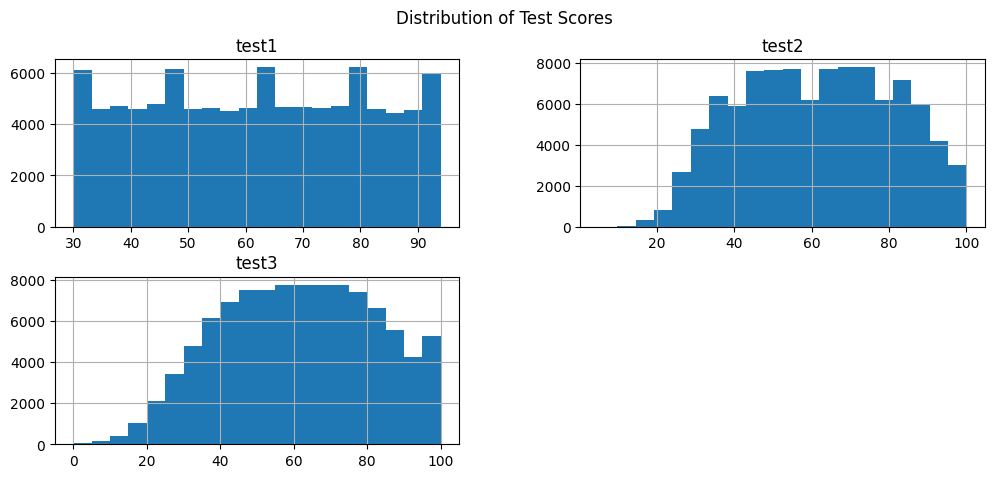

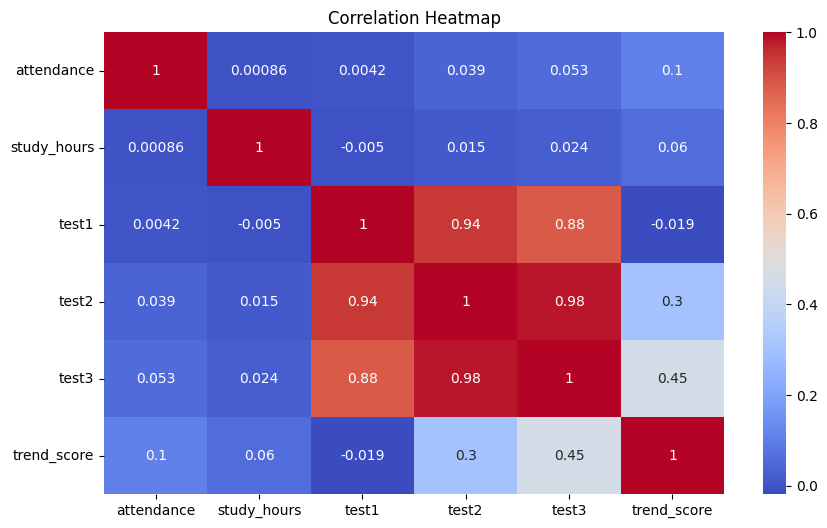

Fitting 2 folds for each of 10 candidates, totalling 20 fits

 Best Parameters Found:
{'bootstrap': True, 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 224}

 Final Accuracy After Tuning: 99.92%

 Classification Report:
              precision    recall  f1-score   support

   Declining       1.00      1.00      1.00      3478
   Improving       1.00      0.99      1.00      2339
      Stable       1.00      1.00      1.00     14183

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



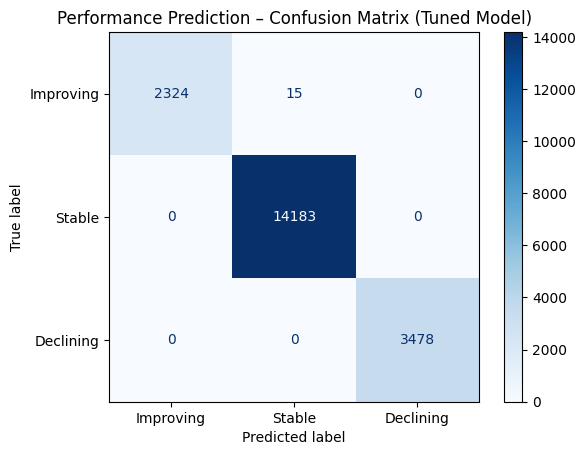

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import randint

# Load dataset
df = pd.read_csv("Adapative_performance.csv")
# Drop column
df = df.drop("parent_education_level", axis=1)

#Data Inspection
df.head()
df.describe()
df.info()
df.shape

# Data Cleaning
df = df.drop_duplicates()
df.fillna(df.median(numeric_only=True), inplace=True)

#EDA
# Distribution of Test Scores
df[['test1','test2','test3']].hist(figsize=(12,5), bins=20)
plt.suptitle("Distribution of Test Scores")
plt.show()

# Create Trend Score
df['trend_score'] = df['test3'] - df['test1']


#Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['attendance','study_hours','test1','test2','test3','trend_score']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#Feature Engineering
# Label Encode Gender
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df.head()
# Assign Labels
def assign_label(x):
    if x > 10:
        return "Improving"
    elif x < -10:
        return "Declining"
    else:
        return "Stable"

df['performance_label'] = df['trend_score'].apply(assign_label)

# Features & Target
X = df[['attendance','study_hours','test1','test2','test3','gender']]
y = df['performance_label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#  HYPERPARAMETER TUNING

param_dist = {
    "n_estimators": randint(150, 300),
    "max_depth": randint(8, 15),
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(1, 3),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

#Model Training
rf = RandomForestClassifier(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#Fit the data
random_search.fit(X_train, y_train)

print("\n Best Parameters Found:")
print(random_search.best_params_)

# Train Final Model with Best Params
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Final Accuracy After Tuning: {accuracy * 100:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Improving','Stable','Declining'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Improving','Stable','Declining'])
disp.plot(cmap="Blues")
plt.title("Performance Prediction – Confusion Matrix (Tuned Model)")
plt.show()


In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.99925


In [15]:
print(classification_report(y_test, y_pred))

import pickle

# Save model
with open("student_performance_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

# Save LabelEncoder
with open("gender_label_encoder.pkl", "wb") as file:
    pickle.dump(le, file)

# Save Feature Columns
feature_names = list(X.columns)
with open("feature_columns.pkl", "wb") as file:
    pickle.dump(feature_names, file)

print("Model and encoders saved successfully!")


              precision    recall  f1-score   support

   Declining       1.00      1.00      1.00      3478
   Improving       1.00      0.99      1.00      2339
      Stable       1.00      1.00      1.00     14183

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Model and encoders saved successfully!


In [16]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [9]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

st.title("Student Performance Prediction using Student ID")

uploaded_file = st.file_uploader("Upload CSV file", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)

    # Remove column if exists
    if "parent_education_level" in df.columns:
        df = df.drop("parent_education_level", axis=1)

    # Clean data
    df = df.drop_duplicates()
    df.fillna(df.median(numeric_only=True), inplace=True)

    # Trend score
    df["trend_score"] = df["test3"] - df["test1"]

    # Label encoding
    le = LabelEncoder()
    df["gender"] = le.fit_transform(df["gender"])

    # Assign label
    def assign_label(x):
        if x > 5:
            return "Improving"
        elif x < -5:
            return "Declining"
        else:
            return "Stable"

    df["performance_label"] = df["trend_score"].apply(assign_label)

    # Model Training (runs once)
    features = ['attendance','study_hours','test1','test2','test3','gender']
    X = df[features]
    y = df["performance_label"]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    )

    model.fit(X_train, Y_train)

    # -----------------------------------------------------------
    #             STUDENT ID PREDICTION ONLY
    st.subheader("🎯 Predict Performance by Student ID")

    if "student_id" in df.columns:

        student_ids = sorted(df["student_id"].unique())
        selected_id = st.selectbox("Select Student ID", student_ids)

        if st.button("Predict Performance"):
            student_row = df[df["student_id"] == selected_id].iloc[0]

            input_data = np.array([[
                student_row["attendance"],
                student_row["study_hours"],
                student_row["test1"],
                student_row["test2"],
                student_row["test3"],
                student_row["gender"]
            ]])

            result = model.predict(input_data)[0]

            st.success(f"🧾 Student ID: {selected_id}\n### Prediction: *{result}*")

    else:
        st.error("⚠ student_id column not found in dataset")


Overwriting app.py
